## Classifying cells

Here I develop my idea of a very simple nearest-neighbor classifier to find cells of a type

In [22]:
import numpy as np
import scipy as sp
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import seaborn
import itertools as it
import h5py
exec( open( "log_progress.py" ).read() )

First, load the AnnData object with UMI counts and metadata

In [2]:
cnts = sc.read_h5ad( "Tabula_muris_10x.h5ad" )
cnts

AnnData object with n_obs × n_vars = 55656 × 23433 
    obs: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

The counts are given in a compressed sparse row (CSR) matrix:

In [4]:
cnts.X.__class__

scipy.sparse.csr.csr_matrix

This is good to quickly get expression vectors for cells but not to get expression of one gene for all cells, as we need next. Luckily, Scanpy allows to simply transpose the whole thing:

In [5]:
cntsT = cnts.transpose()
cntsT

AnnData object with n_obs × n_vars = 23433 × 55656 
    var: 'tissue', 'channel', 'cell_ontology_class', 'cell_ontology_id', 'channel.y', 'cluster.ids', 'free_annotation', 'mouse.id', 'mouse.sex', 'subsetA', 'subsetA_cluster.ids', 'subsetB', 'subsetB_cluster.ids', 'subtissue', 'tissue_tSNE_1', 'tissue_tSNE_2', 'batch'

My test case will be endothelial cells (inner lining of blood vessels). These cells appear in most of the tissues, which makes them interesting. In the Tabula muris tissue supplement, they used different markers depending on tissue, but nearly always included Pecam1 (a.k.a. CD31), a protein found on the surface of endothelial cells as well as various blood cells and for Cadherin-5 (Cdh5, CD144). I am not quite sure yet whether these two markers are together sufficiently specific to catch only endothelial cells, but for now I will assume so. 

I select cells with more than minimal expression of the two markers, and call these my "gold-standard" endothelial cells.

In [6]:
cnts.obs["endo_gold"] = ( cntsT["Pecam1",:].X > 3 ) & ( cntsT["Cdh5",:].X > 3 )

I check what cell types the Tabula muris authors have assigned in their Seurat-based analysis to the cells that I have just picked as "gold" endothelial cells.

In [9]:
cnts[ cnts.obs.endo_gold, : ].obs.cell_ontology_class.value_counts()

endothelial cell                        612
lung endothelial cell                   193
kidney capillary endothelial cell        72
endocardial cell                         29
macrophage                                2
stromal cell                              1
myeloid cell                              1
mesenchymal stem cell                     1
leukocyte                                 1
endothelial cell of hepatic sinusoid      1
Name: cell_ontology_class, dtype: int64

This seems to have worked quite well so far. (Note that the endocardium is simply the endothelium of the heart, i.e., these are endothelial cells, too.) Only 6 false positives in 915 cells. And maybe these aren't false, either, but were wrongly classified in the Seurat analysis.

However, we have probably missed many endothelial cells where the sequencing has failed to detect the two marker genes. The idea is now that we can probably still recognize them as being intermixed between the gold endothelial cells.

Hence, I open the similarity score matrix file, that I have created in 

In [11]:
h5f = h5py.File( "sims.hdf5", "r" )
h5sim = h5f["sim_matrix"]

As a preparation, I find for each cell its *k*=20 nearest neighbors, storing this in an array `nn`. This can be done quickly, in less than a minute, thanks to numpy's `argpartition` function, which allows me to bring the *k* smallest distances to the front and then sort only them.

Afterwars `nn[i,j]` contains the index (row number in `cnts.X`) of the $(j+1)$-th nearest neighbor of the cell with index $i$, i.e., column 0 contains the nearest, column 1 the next-to-nearest neighbors etc.

In [24]:
k = 20
nn = np.empty( ( cnts.n_obs, k ), 'i' )
for i in log_progress( range(cnts.n_obs) ):
    a = -h5sim[ i, : ]
    argpart = a.argpartition(k+1)[:(k+1)]
    nn[i,:] = argpart[ a[argpart].argsort() ][1:]


I use this now to count for each cell how many of its 10 nearest neighbors are among the "gold endothelial" cells.

In [41]:
a = np.full( (cnts.n_obs,), -1 )
for i in log_progress( range(cnts.n_obs) ):
    a[i] = cnts.obs.endo_gold[ nn[i,:10] ].sum()
cnts.obs["n_endo_gold_nghbrs"] = a        

Let's make a histogram of these values, with stacked bars splitting by cells that are themselves endo-gold (orange) and the others (blue).

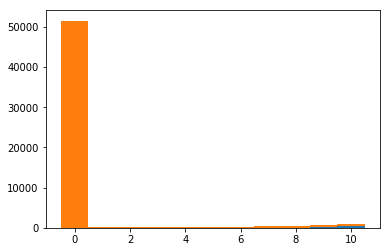

In [42]:
plt.hist( 
    [ cnts[  cnts.obs.endo_gold ].obs.n_endo_gold_nghbrs, 
      cnts[ ~cnts.obs.endo_gold ].obs.n_endo_gold_nghbrs  ],
    stacked=True, bins=np.arange(-.5,11.5) );

Blow up the y axis.

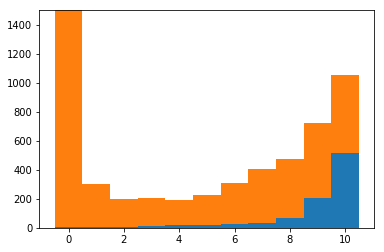

In [45]:
plt.hist( 
    [ cnts[  cnts.obs.endo_gold, : ].obs.n_endo_gold_nghbrs, 
      cnts[ ~cnts.obs.endo_gold, : ].obs.n_endo_gold_nghbrs  ],
    stacked=True, bins=np.arange(-.5,11.5) );
plt.ylim(0,1500);

---------------

[from here on junk]

In [46]:
pd.crosstab( cnts.obs.cell_ontology_class, [ cnts.obs.endo_gold, cnts.obs.n_endo_gold_nghbrs > 2], dropna=False )

endo_gold                                          False       True       
n_endo_gold_nghbrs                                 False True  False True 
cell_ontology_class                                                       
B cell                                              8294     0     0     0
DN1 thymic pro-T cell                                 44     0     0     0
Fraction A pre-pro B cell                             66     0     0     0
Langerhans cell                                       38     0     0     0
T cell                                              4408     1     0     0
alveolar macrophage                                  345     0     0     0
basal cell                                           392     0     0     0
basal cell of epidermis                             4424     0     0     0
basophil                                              61     0     0     0
bladder cell                                        1203     0     0     0
bladder urothelial cell                             1167     0     0     0
blood cell                                          1139     0     0     0
cardiac muscle cell                                   60     0     0     0
ciliated columnar cell of tracheobronchial tree       49     0     0     0
classical monocyte                                   161     0     0     0
dendritic cell                                        42     0     0     0
duct epithelial cell                                  27     0     0     0
early pro-B cell                                      65     0     0     0
endocardial cell                                       0    34     0    29
endothelial cell                                     236  1995     7   605
endothelial cell of hepatic sinusoid                  16    11     0     1
epithelial cell                                      892     0     0     0
erythroblast                                         155     0     0     0
erythrocyte                                           81     0     0     0
fibroblast                                           216    10     0     0
granulocyte                                          725     0     0     0
granulocytopoietic cell                              378     0     0     0
hematopoietic precursor cell                         390     2     0     0
hepatocyte                                          1764     0     0     0
immature B cell                                      113     0     0     0
immature T cell                                     1354     0     0     0
keratinocyte                                        3076     0     0     0
kidney capillary endothelial cell                      4   316     0    72
kidney cell                                           45     0     0     0
kidney collecting duct epithelial cell               435     8     0     0
kidney loop of Henle ascending limb epithelial ...   471     0     0     0
kidney proximal straight tubule epithelial cell     1198     0     0     0
late pro-B cell                                      265     0     0     0
leukocyte                                            247     3     0     1
luminal epithelial cell of mammary gland             459     0     0     0
lung endothelial cell                                 22   247     3   190
macrophage                                          1315     3     2     0
mast cell                                             24     0     0     0
mesangial cell                                        38    13     0     0
mesenchymal cell                                    7848     0     0     0
mesenchymal stem cell                               1135     0     1     0
monocyte                                             525     0     0     0
myeloid cell                                          86     0     1     0
natural killer cell                                 1096     0     0     0
neuroendocrine cell                                  354     8     0     0
non-classical monocyte   

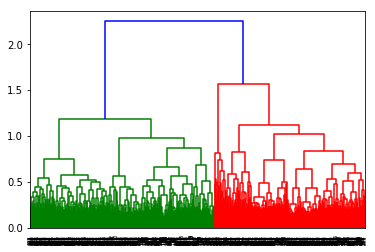

In [29]:
a = h5sim[ cnts.obs.endo_gold, : ][ : , cnts.obs.endo_gold ]
cl = sp.cluster.hierarchy.complete( np.sqrt( 1 - a/2 ) ) 
sp.cluster.hierarchy.dendrogram( cl );

In [72]:
pd.crosstab( 
    cnts.obs.cell_ontology_class[ cnts.obs.endo_gold ], 
    sp.cluster.hierarchy.cut_tree( cl, 2 ).transpose()[0], dropna=False )

col_0,0,1
cell_ontology_class,,
B cell,0,0
DN1 thymic pro-T cell,0,0
Fraction A pre-pro B cell,0,0
Langerhans cell,0,0
T cell,0,0
alveolar macrophage,0,0
basal cell,0,0
basal cell of epidermis,0,0
basophil,0,0


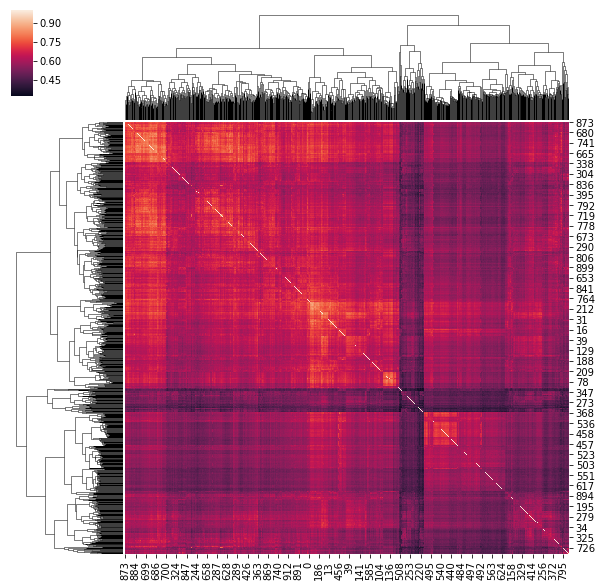

In [25]:
seaborn.clustermap( h5sim[ cnts.obs.endo_gold, : ][ : , cnts.obs.endo_gold ] );